# Finding features for events
The purpose of this notebook is to find meaningful features based on the events table.

### Specific goals
- Correlation between age and number of days without events
- Correlation between age and number of hours without events
- Correlation between gender and number of days without events
- Correlation between gender and number of hours without events
- Correlation between age and min, max, mean and std of events per day
- Correlation between age and min, max, mean and std of events per hour
- Correlation between gender and min, max, mean and std of events per day
- Correlation between gender and min, max, mean and std of events per hour
- Correlation between gender and number of events in the morning, afternoon, evening and night
- Correlation between age and number of events in the morning, afternoon, evening and night
- Correlation between gender and number of events in the week and weekend
- Correlation between age and number of events in the week and weekend

### Observations
- Males have in general more events, more often per day and per hour
- Older people have in general more events, more often per day and per hour
- Good predictors are in this order: sum, max, mean, std
- There are no specific hours or specific days that a gender or age group has more events
- In the weekends and periods of the days specific genders or age do not have more events

### Conclusions
Useful features for devices are:
- Number of hours with or without events
- Number of days with or without events
- Number of events per hour (sum, max, mean, std)
- Number of events per day (sum, max, mean, std)

### To-do:
Investigate in the future:
- Investigate per day of the week


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
dir_in = './data_ori/'

## Import data
I only want to use the events and train table and only care about devices that have at least one event_id (around 31% of devices).

In [2]:
# Load data and make timestamp is a datetime type
train = pd.read_csv(dir_in + 'gender_age_train.csv')
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
events = pd.read_csv(dir_in + 'events.csv', parse_dates=['timestamp'], date_parser=dateparse)

# Here I only care about devices with events -> inner join
train = pd.merge(train, events, how='inner', on='device_id')
def unpack_date(df, date_col):
    # Create columns for elements of date_col
    di=pd.DatetimeIndex(df[date_col])
    
    df[date_col+'_h'] = di.hour
    df[date_col+'_d'] = di.day
    
    return df

def age_group(sex, age):
    # Convert age column to age group
    #ageGroupsF = ['23-','24-26','27-28','29-32','33-42,''43+']
    #ageGroupsM = ['22-','23-26','27-28','29-31','32-38,''39+']

    if sex not in ['M','F']:
        ValueError('%s is not a valid gender' % sex)
        
    if age not in range(100):
        ValueError('%s is not a valid age' % age)
    
    if sex=="M":
        if age<=22:
            g = 0
        elif age<=26:
            g = 1
        elif age<=28:
            g = 2
        elif age<=31:
            g = 3
        elif age<=38:
            g = 4
        else:
            g = 5
    elif sex=="F":
        if age<=23:
            g = 0
        elif age<=26:
            g = 1
        elif age<=28:
            g = 2
        elif age<=32:
            g = 3
        elif age<=42:
            g = 4
        else:
            g = 5
    
    return g
train = unpack_date(train, 'timestamp')
train['age_group'] = train[['gender','age']].apply(lambda x: age_group(x[0],x[1]), axis=1)
train.drop(['age','group'], axis=1, inplace=True)

# Total number of events

### Validation
Let's first check whether our data make sense.

In [256]:
train[train.device_id.isin([ 6352067998666467520,7477216237379271436])]

,device_id,gender,event_id,timestamp,longitude,latitude,timestamp_h,timestamp_d,age_group
1,7477216237379271436,F,280934,2016-05-04 14:10:03,119.57,31.75,14,4,4
2,7477216237379271436,F,363585,2016-05-04 14:13:30,119.57,31.75,14,4,4
3,7477216237379271436,F,935225,2016-05-06 18:51:15,0.00,0.00,18,6,4
4,7477216237379271436,F,1551108,2016-05-04 14:09:29,119.57,31.75,14,4,4
5,7477216237379271436,F,1901681,2016-05-04 14:10:00,119.57,31.75,14,4,4
6,7477216237379271436,F,1969680,2016-05-04 14:08:17,119.59,31.75,14,4,4
7,7477216237379271436,F,2616450,2016-05-04 14:08:23,119.57,31.75,14,4,4
8,6352067998666467520,M,7665,2016-05-05 09:36:50,0.00,0.00,9,5,4
9,6352067998666467520,M,223251,2016-05-05 10:44:38,0.00,0.00,10,5,4
10,6352067998666467520,M,375447,2016-05-05 12:52:14,0.00,0.00,12,5,4


So device 6352067998666467520 had 11 events on 3 different days, and 7477216237379271436 has 7 events on 2 different days.

In [258]:
counts=train.groupby(['gender','device_id','timestamp_d']).timestamp_d.size().unstack('gender')
counts.head(10)
# Each number in table below denotes the number of evens during that hour for that device.
# NaNs are ignored while calculating mean, min, max, sum and std, so do not replace them by 0

gender                               F     M
device_id            timestamp_d            
-9222956879900151005 6             NaN  30.0
                     7             NaN  35.0
-9221026417907250887 1            32.0   NaN
                     2            37.0   NaN
                     3            16.0   NaN
                     4            19.0   NaN
                     5            20.0   NaN
                     6            14.0   NaN
                     7             9.0   NaN
-9220830859283101130 3             NaN   1.0

In [259]:
counts.mean()

gender
F    10.854406
M    13.360483
dtype: float64

In [260]:
counts.sum()

gender
F    351292.0
M    864303.0
dtype: float64

In [263]:
counts=train.groupby(['age_group','device_id','timestamp_d']).timestamp_d.size().unstack('age_group')
counts.head(10)

age_group                           0   1   2     3     4   5
device_id            timestamp_d                             
-9222956879900151005 6            NaN NaN NaN   NaN  30.0 NaN
                     7            NaN NaN NaN   NaN  35.0 NaN
-9221026417907250887 1            NaN NaN NaN  32.0   NaN NaN
                     2            NaN NaN NaN  37.0   NaN NaN
                     3            NaN NaN NaN  16.0   NaN NaN
                     4            NaN NaN NaN  19.0   NaN NaN
                     5            NaN NaN NaN  20.0   NaN NaN
                     6            NaN NaN NaN  14.0   NaN NaN
                     7            NaN NaN NaN   9.0   NaN NaN
-9220830859283101130 3            1.0 NaN NaN   NaN   NaN NaN

In [264]:
counts.mean()

age_group
0    10.108474
1    12.014901
2    12.145909
3    12.495100
4    13.083209
5    13.881155
dtype: float64

In [265]:
counts.sum()

age_group
0    118815.0
1    183840.0
2    130192.0
3    197610.0
4    298742.0
5    286396.0
dtype: float64

Conclusion so-far: older and male have more events.

### Relation between gender and number of days without events
Let's see if there is a correlation between the gender and the number of days without events (NaN)

In [247]:
count = train.groupby(['gender','device_id','timestamp_d']).timestamp_d.nunique().unstack(['timestamp_d'])
count = 8-count.sum(axis=1).to_frame('days without events')
count.head(5)

days without events
gender device_id                                
F      -9221026417907250887                  1.0
       -9218960997324667698                  4.0
       -9216200545381120263                  7.0
       -9215766592714662253                  7.0
       -9214243372173201436                  5.0

                     days without events     
gender                                 F    M
device_id                                    
-9222956879900151005                 NaN  6.0
-9221026417907250887                 1.0  NaN
-9220830859283101130                 NaN  5.0
-9220061629197656378                 NaN  1.0
-9218960997324667698                 4.0  NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1342b5dd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13397d350>]], dtype=object)

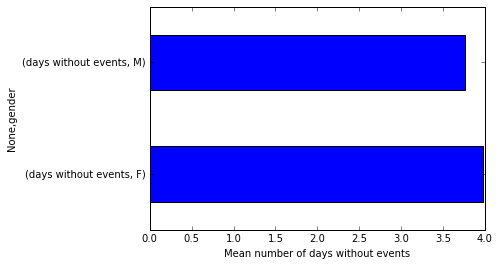

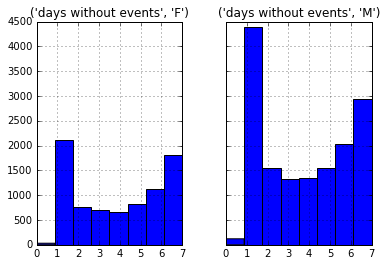

In [248]:
print count.unstack('gender').head(5)
count.unstack('gender').mean().plot(kind='barh')
plt.xlabel('Mean number of days without events')
count.unstack('gender').hist(bins=8, sharex=True, sharey=True)

Conclusion: females have slightly more days without events, but not significantly.

### Relation between age and number of days without events

Let's see if there is a relation between age and number of days without events.

In [249]:
count = train.groupby(['age_group','device_id','timestamp_d']).timestamp_d.nunique().unstack(['timestamp_d'])
count = 8-count.sum(axis=1).to_frame('days without events')
count.head(5)

days without events
age_group device_id                                
0         -9220830859283101130                  5.0
          -9215352913819638805                  7.0
          -9212424538588397592                  7.0
          -9208560418953812508                  2.0
          -9206202041936929793                  1.0

                     days without events                       
age_group                              0   1   2    3    4    5
device_id                                                      
-9222956879900151005                 NaN NaN NaN  NaN  6.0  NaN
-9221026417907250887                 NaN NaN NaN  1.0  NaN  NaN
-9220830859283101130                 5.0 NaN NaN  NaN  NaN  NaN
-9220061629197656378                 NaN NaN NaN  NaN  NaN  1.0
-9218960997324667698                 NaN NaN NaN  NaN  NaN  4.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1cd1ce5d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c18d8410>]], dtype=object)

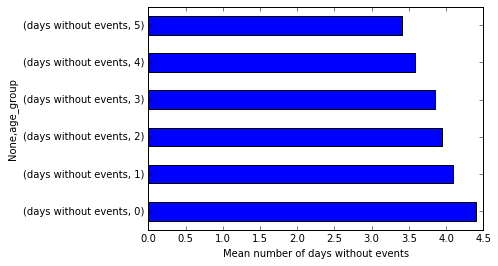

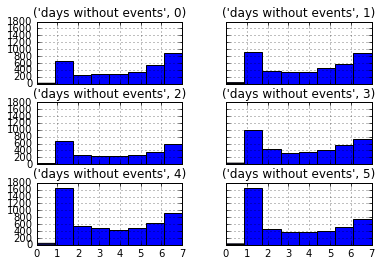

In [250]:
print count.unstack('age_group').head(5)
count.unstack('age_group').mean().plot(kind='barh')
plt.xlabel('Mean number of days without events')
count.unstack('age_group').hist(bins=8, sharex=True, sharey=True)

Conclusion: older people generally have less days without events. This is because older people have more often events on every day (column 1).

### Relation between age and number of hours without events

In [251]:
count = train.groupby(['age_group','device_id','timestamp_h']).timestamp_h.nunique().unstack(['timestamp_h'])
count = 24-count.sum(axis=1).to_frame('hours without events')
count.head(5)
count.max()

hours without events    23.0
dtype: float64

                     hours without events                         
age_group                               0   1   2    3     4     5
device_id                                                         
-9222956879900151005                  NaN NaN NaN  NaN  15.0   NaN
-9221026417907250887                  NaN NaN NaN  8.0   NaN   NaN
-9220830859283101130                 20.0 NaN NaN  NaN   NaN   NaN
-9220061629197656378                  NaN NaN NaN  NaN   NaN  10.0
-9218960997324667698                  NaN NaN NaN  NaN   NaN  20.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131e3e950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x131c40d90>]], dtype=object)

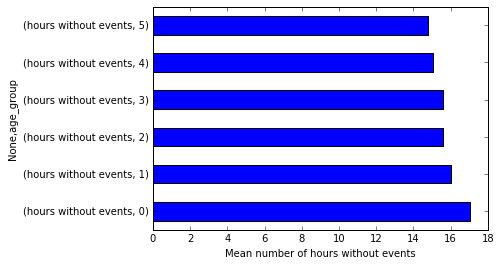

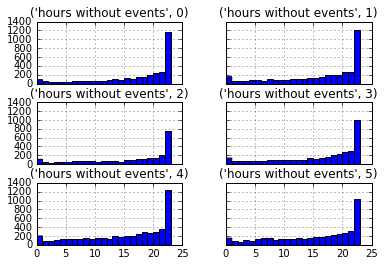

In [252]:
print count.unstack('age_group').head(5)
count.unstack('age_group').mean().plot(kind='barh')
plt.xlabel('Mean number of hours without events')
count.unstack('age_group').hist(bins=23, sharex=True, sharey=True)

Conclusion: young people events are more focused on specific hours of the day.

## Number of events

### Number of events per day and gender

In [18]:
count = train.groupby(['gender','device_id','timestamp_d']).size().unstack(['gender', 'timestamp_d'])
#count.fillna(0, inplace=True)a

In [19]:
count.head()

gender                   F                                            M        \
timestamp_d             1     2     3     4     5     6    7   30    6     7    
device_id                                                                       
-9222956879900151005   NaN   NaN   NaN   NaN   NaN   NaN  NaN NaN  30.0  35.0   
-9221026417907250887  32.0  37.0  16.0  19.0  20.0  14.0  9.0 NaN   NaN   NaN   
-9220830859283101130   NaN   NaN   NaN   NaN   NaN   NaN  NaN NaN   NaN   2.0   
-9220061629197656378   NaN   NaN   NaN   NaN   NaN   NaN  NaN NaN   1.0   1.0   
-9218960997324667698   NaN   1.0   1.0   NaN   NaN   1.0  3.0 NaN   NaN   NaN   

gender                                                    
timestamp_d             3     5    1    2     4   30  8   
device_id                                                 
-9222956879900151005   NaN   NaN  NaN  NaN   NaN NaN NaN  
-9221026417907250887   NaN   NaN  NaN  NaN   NaN NaN NaN  
-9220830859283101130   1.0   5.0  NaN  NaN   NaN NaN NaN  
-9220061629197656378  12.0  17.0  6.0  2.0  13.0 NaN NaN  
-9218960997324667698   NaN   NaN  NaN  NaN   NaN NaN NaN

gender,F,M
timestamp_d,,
1,10.313691,12.868098
2,10.780321,13.081595
3,10.946169,14.105246
4,11.001301,13.726931
5,11.224778,13.570603
6,11.028346,13.565595
7,10.770200,12.800767
8,NaN,1.000000
30,1.481481,1.784431


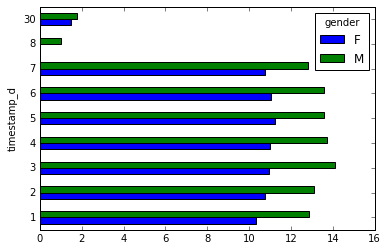

In [20]:
mean_gender = count.mean().unstack('gender')
mean_gender.plot(kind='barh')
mean_gender

Not really. This looks fairly constant. Make no sense to further investigate day dependence for gender. Lets have a look per hour. Following line confirms.

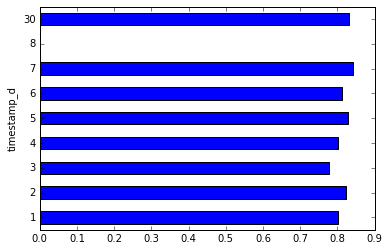

In [21]:
np.divide(mean_gender['F'],mean_gender['M']).plot(kind='barh')

In [25]:
train.groupby(['gender','device_id','timestamp_d']).size().head(5)

gender  device_id             timestamp_d
F       -9221026417907250887  1              32
                              2              37
                              3              16
                              4              19
                              5              20
dtype: int64

In [27]:
train.groupby(['gender','device_id','timestamp_d']).size().unstack('timestamp_d').head(5)

timestamp_d                    1     2     3     4     5     6    7   8   30
gender device_id                                                            
F      -9221026417907250887  32.0  37.0  16.0  19.0  20.0  14.0  9.0 NaN NaN
       -9218960997324667698   NaN   1.0   1.0   NaN   NaN   1.0  3.0 NaN NaN
       -9216200545381120263   NaN   1.0   NaN   NaN   NaN   NaN  NaN NaN NaN
       -9215766592714662253   NaN   NaN   NaN   NaN   1.0   NaN  NaN NaN NaN
       -9214243372173201436   NaN   1.0   1.0   NaN   1.0   NaN  NaN NaN NaN

### Number of events per day and gender

In [191]:
count = train.groupby(['gender','device_id','timestamp_d']).size()
count.unstack('timestamp_d').head(5)

timestamp_d                    1     2     3     4     5     6    7   8   30
gender device_id                                                            
F      -9221026417907250887  32.0  37.0  16.0  19.0  20.0  14.0  9.0 NaN NaN
       -9218960997324667698   NaN   1.0   1.0   NaN   NaN   1.0  3.0 NaN NaN
       -9216200545381120263   NaN   1.0   NaN   NaN   NaN   NaN  NaN NaN NaN
       -9215766592714662253   NaN   NaN   NaN   NaN   1.0   NaN  NaN NaN NaN
       -9214243372173201436   NaN   1.0   1.0   NaN   1.0   NaN  NaN NaN NaN

In [193]:
count.unstack('timestamp_d').max(axis=1).unstack('gender').head(5)

gender,F,M
device_id,,
-9222956879900151005,NaN,35.0
-9221026417907250887,37.0,NaN
-9220830859283101130,NaN,5.0
-9220061629197656378,NaN,17.0
-9218960997324667698,3.0,NaN


(0.7, 0.9)

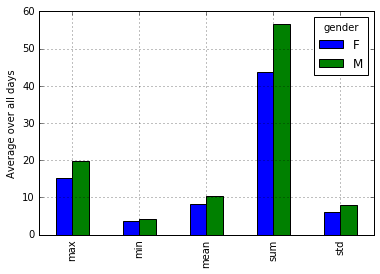

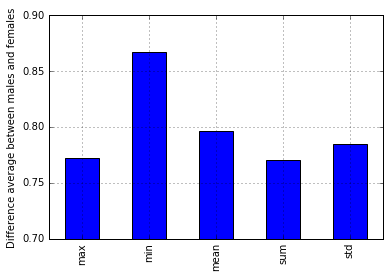

In [206]:
df = pd.DataFrame()
df['max'] = count.unstack('timestamp_d').max(axis=1).unstack('gender').mean()
df['min'] = count.unstack('timestamp_d').min(axis=1).unstack('gender').mean()
df['mean'] = count.unstack('timestamp_d').mean(axis=1).unstack('gender').mean()
df['sum'] = count.unstack('timestamp_d').sum(axis=1).unstack('gender').mean()
df['std'] = count.unstack('timestamp_d').std(axis=1).unstack('gender').mean()

plt.figure()
df.transpose().plot.bar()
plt.grid()
plt.ylabel('Average over all days')

plt.figure()
df.apply(lambda x: x[0]/x[1]).transpose().plot.bar()
plt.grid()
plt.ylabel('Difference average between males and females')
plt.ylim([0.7,0.9])

### Number of events per day and age group

(0.5, 0.9)

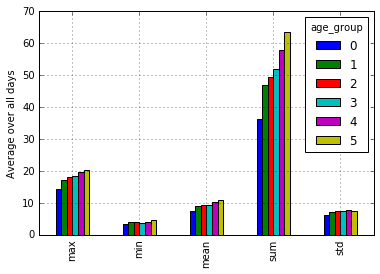

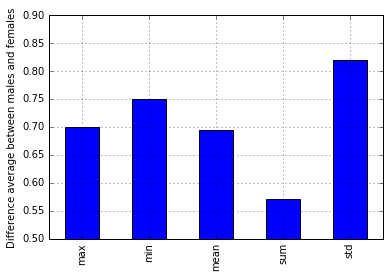

In [212]:
count = train.groupby(['age_group','device_id','timestamp_d']).size()

df = pd.DataFrame()
df['max'] = count.unstack('timestamp_d').max(axis=1).unstack('age_group').mean()
df['min'] = count.unstack('timestamp_d').min(axis=1).unstack('age_group').mean()
df['mean'] = count.unstack('timestamp_d').mean(axis=1).unstack('age_group').mean()
df['sum'] = count.unstack('timestamp_d').sum(axis=1).unstack('age_group').mean()
df['std'] = count.unstack('timestamp_d').std(axis=1).unstack('age_group').mean()

plt.figure()
df.transpose().plot.bar()
plt.grid()
plt.ylabel('Average over all days')

plt.figure()
df.apply(lambda x: x[0]/max(x)).transpose().plot.bar()
plt.grid()
plt.ylabel('Difference average between males and females')
plt.ylim([0.5,0.9])

### Number of events per hour and gender

(0.6, 1.1)

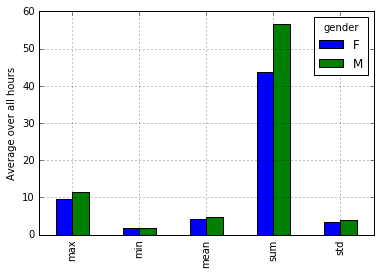

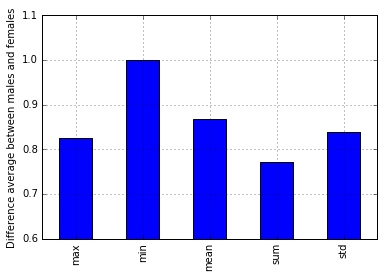

In [218]:
count = train.groupby(['gender','device_id','timestamp_h']).size()

df = pd.DataFrame()
df['max'] = count.unstack('timestamp_h').max(axis=1).unstack('gender').mean()
df['min'] = count.unstack('timestamp_h').min(axis=1).unstack('gender').mean()
df['mean'] = count.unstack('timestamp_h').mean(axis=1).unstack('gender').mean()
df['sum'] = count.unstack('timestamp_h').sum(axis=1).unstack('gender').mean()
df['std'] = count.unstack('timestamp_h').std(axis=1).unstack('gender').mean()

plt.figure()
df.transpose().plot.bar()
plt.grid()
plt.ylabel('Average over all hours')

plt.figure()
df.apply(lambda x: x[0]/max(x)).transpose().plot.bar()
plt.grid()
plt.ylabel('Difference average between males and females')
plt.ylim([0.6,1.1])

### Number of events per hour and age group

(0.5, 1.1)

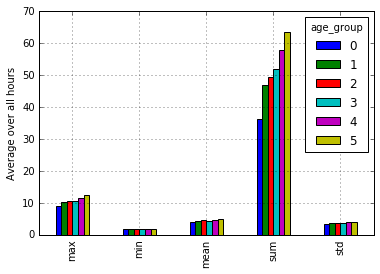

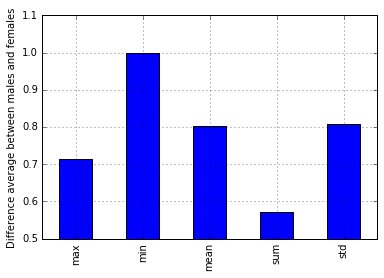

In [220]:
count = train.groupby(['age_group','device_id','timestamp_h']).size()

df = pd.DataFrame()
df['max'] = count.unstack('timestamp_h').max(axis=1).unstack('age_group').mean()
df['min'] = count.unstack('timestamp_h').min(axis=1).unstack('age_group').mean()
df['mean'] = count.unstack('timestamp_h').mean(axis=1).unstack('age_group').mean()
df['sum'] = count.unstack('timestamp_h').sum(axis=1).unstack('age_group').mean()
df['std'] = count.unstack('timestamp_h').std(axis=1).unstack('age_group').mean()

plt.figure()
df.transpose().plot.bar()
plt.grid()
plt.ylabel('Average over all hours')

plt.figure()
df.apply(lambda x: x[0]/max(x)).transpose().plot.bar()
plt.grid()
plt.ylabel('Difference average between males and females')
plt.ylim([0.5,1.1])

## Number of events in the morning, afternoon, evening and night

In [157]:
# Define periods during the day
night = [1,2,3,4,5,6]
morning = [7,8,9,10,11,12]
afternoon = [13,14,15,16,17,18]
evening = [19,20,21,22,23,0]

### Per age group

In [237]:

count = train.groupby(['age_group','device_id','timestamp_h']).size().unstack('timestamp_h')
count.head(5)

timestamp_h                      0    1    2   3   4   5   6     7     8   \
age_group device_id                                                         
0         -9220830859283101130  NaN  NaN  2.0 NaN NaN NaN NaN   NaN   NaN   
          -9215352913819638805  NaN  NaN  NaN NaN NaN NaN NaN   NaN   NaN   
          -9212424538588397592  NaN  NaN  NaN NaN NaN NaN NaN   NaN   NaN   
          -9208560418953812508  NaN  NaN  NaN NaN NaN NaN NaN   NaN   1.0   
          -9206202041936929793  2.0  2.0  2.0 NaN NaN NaN NaN  19.0  15.0   

timestamp_h                      9  ...    14    15    16   17   18   19   20  \
age_group device_id                 ...                                         
0         -9220830859283101130  NaN ...   NaN   NaN   NaN  NaN  NaN  NaN  3.0   
          -9215352913819638805  NaN ...   NaN  14.0   4.0  NaN  NaN  NaN  NaN   
          -9212424538588397592  NaN ...   NaN   1.0   NaN  1.0  NaN  1.0  NaN   
          -9208560418953812508  4.0 ...   NaN   NaN   1.0  1.0  NaN  1.0  NaN   
          -9206202041936929793  8.0 ...   3.0   7.0  21.0  6.0  4.0  5.0  7.0   

timestamp_h                       21   22   23  
age_group device_id                             
0         -9220830859283101130   1.0  NaN  2.0  
          -9215352913819638805   NaN  NaN  NaN  
          -9212424538588397592   NaN  NaN  NaN  
          -9208560418953812508   NaN  NaN  NaN  
          -9206202041936929793  16.0  2.0  4.0  

[5 rows x 24 columns]

In [238]:
count.groupby(level=0).sum().transpose()

age_group,0,1,2,3,4,5
timestamp_h,,,,,,
0,4513.0,8010.0,4774.0,7037.0,11130.0,9400.0
1,2655.0,5516.0,2904.0,4243.0,6239.0,5533.0
2,1945.0,4133.0,2279.0,3473.0,4364.0,4054.0
3,1610.0,3170.0,1831.0,2873.0,3892.0,3615.0
4,1234.0,2708.0,1682.0,2627.0,3803.0,4228.0
5,1602.0,3189.0,2075.0,3679.0,5848.0,8143.0
6,2671.0,5132.0,3706.0,6939.0,11576.0,13946.0
7,4019.0,6754.0,5744.0,8767.0,15167.0,15132.0
8,5015.0,8265.0,6032.0,8948.0,15751.0,15021.0


In [239]:
count.groupby(level=0).sum().transpose().idxmax()

age_group
0    10
1    10
2    21
3    21
4    10
5    21
dtype: int64

In [240]:
count.groupby(level=0).sum().transpose().idxmin()

age_group
0    4
1    4
2    4
3    4
4    4
5    3
dtype: int64

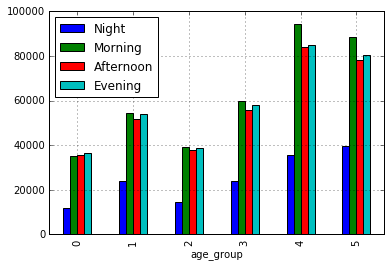

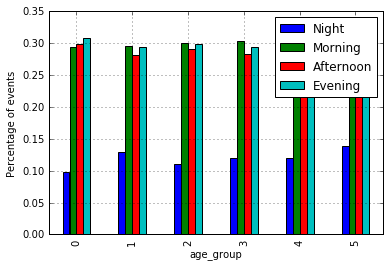

In [241]:
df = count.groupby(level=0).sum().transpose().loc[night].sum().to_frame('Night')
df['Morning'] = count.groupby(level=0).sum().transpose().loc[morning].sum()
df['Afternoon'] = count.groupby(level=0).sum().transpose().loc[afternoon].sum()
df['Evening'] = count.groupby(level=0).sum().transpose().loc[evening].sum()

df.plot.bar()
plt.grid()

plt.figure()
df.transpose().apply(lambda x: x/(x[0]+x[1]+x[2]+x[3]), axis=0).transpose().plot.bar()
plt.ylabel('Percentage of events')
plt.grid()

### Per gender

In [224]:
count = train.groupby(['gender','device_id','timestamp_h']).size().unstack('timestamp_h')
count.head(5)

timestamp_h                  0   1   2   3   4    5    6     7     8    9   \
gender device_id                                                             
F      -9221026417907250887 NaN NaN NaN NaN NaN  NaN  7.0  43.0  10.0  5.0   
       -9218960997324667698 NaN NaN NaN NaN NaN  1.0  NaN   NaN   NaN  NaN   
       -9216200545381120263 NaN NaN NaN NaN NaN  NaN  NaN   NaN   NaN  NaN   
       -9215766592714662253 NaN NaN NaN NaN NaN  NaN  NaN   NaN   NaN  NaN   
       -9214243372173201436 NaN NaN NaN NaN NaN  NaN  NaN   NaN   NaN  NaN   

timestamp_h                 ...    14   15    16   17   18   19    20  21  \
gender device_id            ...                                             
F      -9221026417907250887 ...   NaN  4.0  13.0  2.0  4.0  3.0  26.0 NaN   
       -9218960997324667698 ...   NaN  1.0   NaN  NaN  NaN  NaN   NaN NaN   
       -9216200545381120263 ...   NaN  NaN   NaN  NaN  NaN  NaN   NaN NaN   
       -9215766592714662253 ...   NaN  NaN   NaN  NaN  NaN  1.0   NaN NaN   
       -9214243372173201436 ...   1.0  NaN   NaN  NaN  NaN  NaN   NaN NaN   

timestamp_h                    22   23  
gender device_id                        
F      -9221026417907250887  13.0  3.0  
       -9218960997324667698   3.0  NaN  
       -9216200545381120263   NaN  NaN  
       -9215766592714662253   NaN  NaN  
       -9214243372173201436   NaN  NaN  

[5 rows x 24 columns]

In [225]:
count.groupby(level=0).sum().transpose()

gender,F,M
timestamp_h,,
0,11004.0,33860.0
1,6693.0,20397.0
2,5241.0,15007.0
3,4424.0,12567.0
4,4561.0,11721.0
5,7894.0,16642.0
6,14475.0,29495.0
7,17364.0,38219.0
8,17137.0,41895.0


In [226]:
count.groupby(level=0).sum().transpose().idxmax()

gender
F    21
M    10
dtype: int64

In [227]:
count.groupby(level=0).sum().transpose().idxmin()

gender
F    3
M    4
dtype: int64

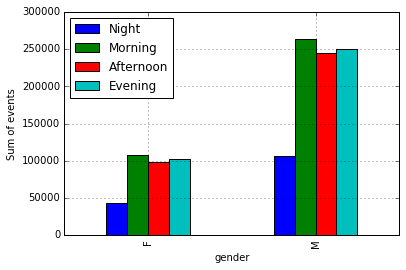

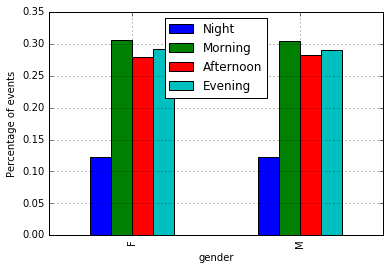

In [235]:
df = count.groupby(level=0).sum().transpose().loc[night].sum().to_frame('Night')
df['Morning'] = count.groupby(level=0).sum().transpose().loc[morning].sum()
df['Afternoon'] = count.groupby(level=0).sum().transpose().loc[afternoon].sum()
df['Evening'] = count.groupby(level=0).sum().transpose().loc[evening].sum()

df.plot.bar()
plt.grid()
plt.ylabel('Sum of events')

plt.figure()
df.transpose().apply(lambda x: x/(x[0]+x[1]+x[2]+x[3]), axis=0).transpose().plot.bar()
plt.ylabel('Percentage of events')
plt.grid()


## Investigate difference during the day / in the weekend

In [169]:
weekdays = [2,3,4,5,6]
weekends = [30,1,7,8]

### Per age group

In [170]:
# Define periods during the day

count = train.groupby(['age_group','device_id','timestamp_d']).size().unstack('timestamp_d')
count.head(5)

timestamp_d                       1    2     3     4     5     6     7   8   \
age_group device_id                                                           
0         -9220830859283101130   NaN  NaN   1.0   NaN   5.0   NaN   2.0 NaN   
          -9215352913819638805   NaN  NaN   NaN   NaN   NaN  18.0   NaN NaN   
          -9212424538588397592   NaN  NaN   NaN   NaN  15.0   NaN   NaN NaN   
          -9208560418953812508   2.0  1.0   NaN   1.0   2.0   1.0   2.0 NaN   
          -9206202041936929793  11.0  8.0  38.0  23.0  41.0  67.0  25.0 NaN   

timestamp_d                     30  
age_group device_id                 
0         -9220830859283101130 NaN  
          -9215352913819638805 NaN  
          -9212424538588397592 NaN  
          -9208560418953812508 NaN  
          -9206202041936929793 NaN

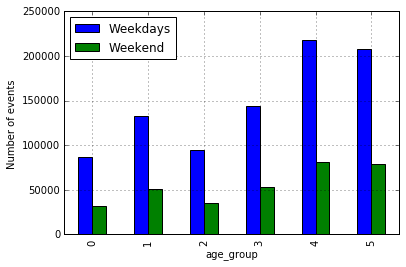

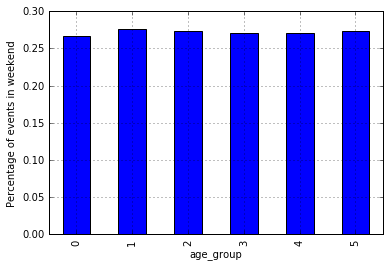

In [177]:
df = count.groupby(level=0).sum().transpose().loc[weekdays].sum().to_frame('Weekdays')
df['Weekend'] = count.groupby(level=0).sum().transpose().loc[weekends].sum()

df.plot.bar()
plt.grid()
plt.ylabel('Number of events')

plt.figure()
df[['Weekend','Weekdays']].transpose().apply(lambda x: x[0]/(x[1] +x[0])).plot.bar()
plt.ylabel('Percentage of events in weekend')
plt.grid()

### Per gender

In [178]:
count = train.groupby(['gender','device_id','timestamp_d']).size().unstack('timestamp_d')
count.head(5)

timestamp_d                    1     2     3     4     5     6    7   8   30
gender device_id                                                            
F      -9221026417907250887  32.0  37.0  16.0  19.0  20.0  14.0  9.0 NaN NaN
       -9218960997324667698   NaN   1.0   1.0   NaN   NaN   1.0  3.0 NaN NaN
       -9216200545381120263   NaN   1.0   NaN   NaN   NaN   NaN  NaN NaN NaN
       -9215766592714662253   NaN   NaN   NaN   NaN   1.0   NaN  NaN NaN NaN
       -9214243372173201436   NaN   1.0   1.0   NaN   1.0   NaN  NaN NaN NaN

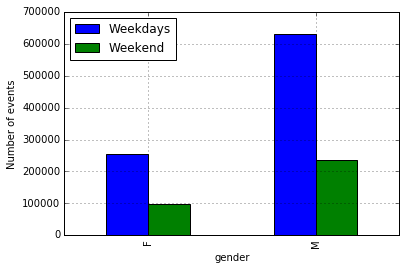

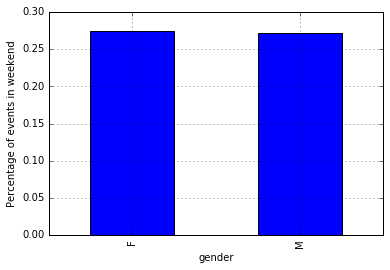

In [179]:
df = count.groupby(level=0).sum().transpose().loc[weekdays].sum().to_frame('Weekdays')
df['Weekend'] = count.groupby(level=0).sum().transpose().loc[weekends].sum()

df.plot.bar()
plt.grid()
plt.ylabel('Number of events')

plt.figure()
df[['Weekend','Weekdays']].transpose().apply(lambda x: x[0]/(x[1] +x[0])).plot.bar()
plt.ylabel('Percentage of events in weekend')
plt.grid()